# Fraud Detection in Electricity and Gas Consumption Challenge


<img src="gasvelectric.png">

# Data Prep

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter('ignore')

## Read the Data

In [2]:
client_train = pd.read_csv('train/client_train.csv', low_memory=False)
invoice_train = pd.read_csv('train/invoice_train.csv', low_memory=False)

client_test = pd.read_csv('test/client_test.csv', low_memory=False)
invoice_test = pd.read_csv('test/invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv('SampleSubmission.csv', low_memory=False)

## Data Understanding

In [3]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_train.shape)

(135493, 6) (4476749, 16) (58069, 5) (4476749, 16)


In [4]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [5]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [6]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [7]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [8]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [9]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [10]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [11]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [12]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [13]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

No missing values in train set

## Statistical Analysis and EDA

In [14]:
from Work_Space import *

In [15]:
L = pd.to_datetime(client_train['creation_date'], dayfirst=True)
client_train['creation_year'] = L.dt.year

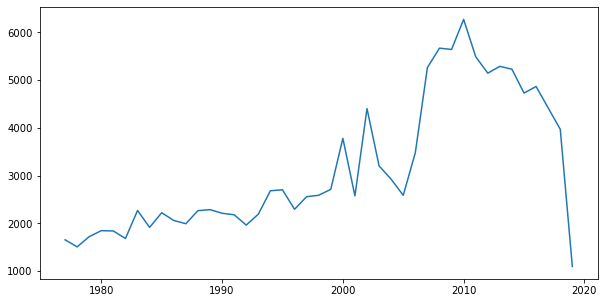

In [16]:
plot_client(client_train)

In [17]:
years=set(L.dt.year)

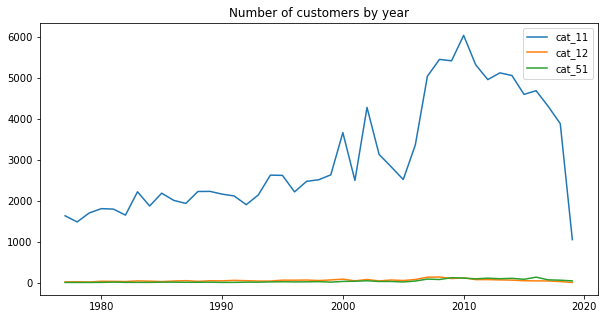

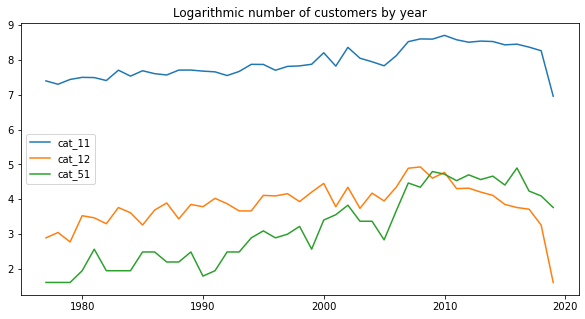

In [18]:
plot_client_per_year(client_train,years)

The number of customers increased over the years 1997 and 2019 especially for client category 11, however, we have up and down from 1999 to 2005 and then starting from 2006 the increase of the number of customers is noticeable, and we noticed the same for the client categories 12 and 51.

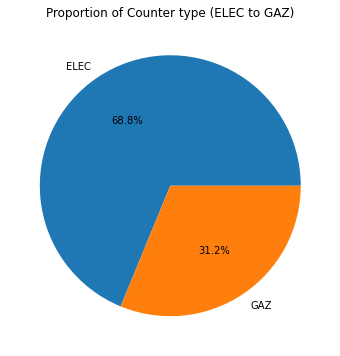

In [19]:
plot_counter_type(invoice_train)

Observation:

    68.8% for the counter type ELEC

    31.2% for the counter type GAZ


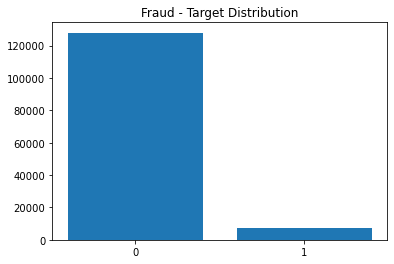

In [20]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

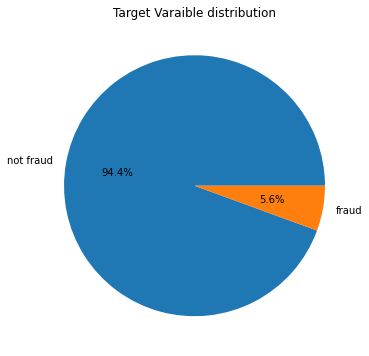

In [21]:
plot_fraud(client_train)

In [22]:
client_train['target'].mean()

0.05584052312665599

The probability of a fraud is P(target=1)=0.05584052312665599

Target is highly imbalanced with fewer cases of fraudulent activities. <strong>Let's specify</strong>

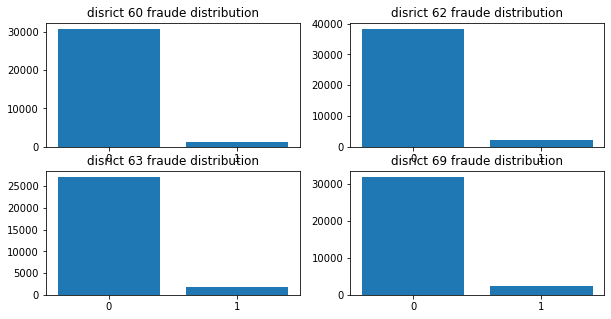

In [30]:
target_distribution_by(client_train,'disrict',(2,2))

In [24]:
client_train[['disrict', 'target']].groupby(['disrict']).mean()

,target
disrict,
60,0.035869
62,0.051619
63,0.065236
69,0.071485


The disrict with the biggest fraud activity is 69 P(target=1|disrict=69)=0.071485

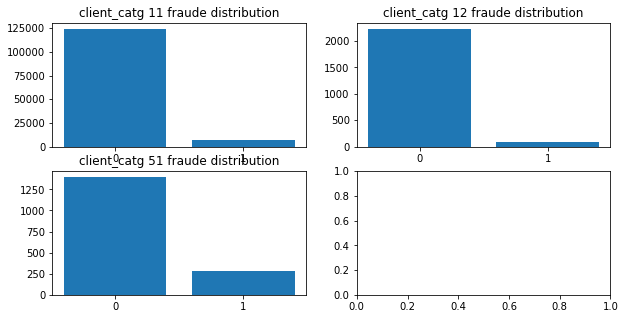

In [31]:
target_distribution_by(client_train,'client_catg',(2,2))

In [26]:
client_train[['client_catg', 'target']].groupby(['client_catg']).mean()

,target
client_catg,
11,0.054687
12,0.039638
51,0.168653


The category with the biggest fraud activity is 51 P(target=1|client_catg=51)=0.168653

In [25]:
client_train[['region', 'target']].groupby(['region']).mean()

,target
region,
101,0.035919
103,0.102967
104,0.055966
105,0.055927
106,0.075071
107,0.065813
199,0.000000
206,0.018868
301,0.033005


The region with the biggest fraud activity is 103 P(target=1|disrict=103)=0.102967

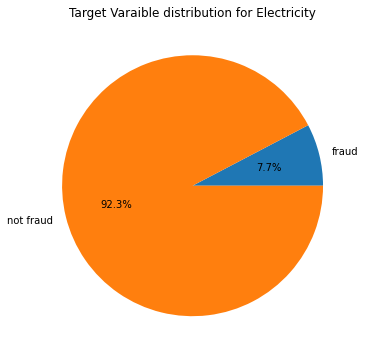

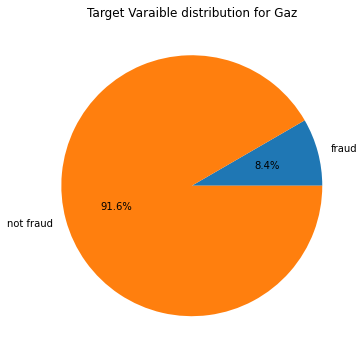

In [28]:
df_counter=farud_by_counter(client_train,invoice_train)

In [29]:
df_counter

,target
counter_type,
ELEC,0.076751
GAZ,0.083561


The probability of a fraud in Electricity is P(target=1|counter_type=ELEC)=0.076751

The probability of a fraud in Gaz is P(target=1|counter_type=GAZ)=0.083561

In [21]:
client_train.drop(['creation_year'], axis=1, inplace=True)

## Feature Engineering (Part 1)

In [27]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [22]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [23]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['disrict'] = client_test['disrict'].astype(int)

In [24]:
def aggregate_by_client_id(invoice_data):
    aggs = {}
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    return pd.merge(df, agg_trans, on='client_id', how='left')

In [25]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)

In [26]:
print(agg_train.shape)
agg_train.head()

(135493, 6)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286


In [27]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')

In [28]:
#aggregate test set
agg_test = aggregate_by_client_id(invoice_test)
test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [29]:
train.shape, test.shape

((135493, 12), (58069, 10))

In [30]:
#drop redundant columns
sub_client_id = test['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

# Benchmark Modelling

## Train LGBM *Classifier*

In [31]:
x_train = train.drop(columns=['target'])
y_train = train['target']

In [32]:
model = LGBMClassifier(boosting_type='gbdt', num_iterationss=500)
model.fit(x_train, y_train)

[LightGBM] [Warning] Unknown parameter: num_iterationss


LGBMClassifier(num_iterationss=500)

In [33]:
x_train.disrict.unique()

array([60, 69, 62, 63])

## Make Predictions on test set

In [29]:
test.columns

Index(['disrict', 'client_catg', 'region', '1transactions_count',
       'consommation_level_1_mean', 'consommation_level_2_mean',
       'consommation_level_3_mean', 'consommation_level_4_mean'],
      dtype='object')

In [30]:
preds = model.predict(test)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

,target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [31]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

,client_id,target
0,test_Client_0,0.0
1,test_Client_1,0.0
2,test_Client_10,0.0
3,test_Client_100,0.0
4,test_Client_1000,0.0


In [38]:
submission.to_csv('output/submission.csv', index=False)

## Feature engeneering (Part 2)

In [19]:
def feature_change(cl, inv):

    cl['client_catg'] = cl['client_catg'].astype('category')
    cl['disrict'] = cl['disrict'].astype('category')
    cl['region'] = cl['region'].astype('category')
    cl['region_group'] = cl['region'].apply(lambda x: 100 if x<100 else 300 if x>300 else 200)
    cl['creation_date'] = pd.to_datetime(cl['creation_date'])
    
    cl['coop_time'] = (2019 - cl['creation_date'].dt.year)*12 - cl['creation_date'].dt.month

    inv['counter_type'] = inv['counter_type'].map({"ELEC":1,"GAZ":0})
    inv['counter_statue'] = inv['counter_statue'].map({0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5})
    
    inv['invoice_date'] = pd.to_datetime(inv['invoice_date'], dayfirst=True)
    inv['invoice_month'] = inv['invoice_date'].dt.month
    inv['invoice_year'] = inv['invoice_date'].dt.year
    inv['is_weekday'] = ((pd.DatetimeIndex(inv.invoice_date).dayofweek) // 5 == 1).astype(float)
    inv['delta_index'] = inv['new_index'] - inv['old_index']
    
    return cl, inv

In [20]:
client_train1, invoice_train1 = feature_change(client_train, invoice_train)
client_test1, invoice_test1 = feature_change(client_test, invoice_test)

In [21]:
client_train1

,disrict,client_id,client_catg,region,creation_date,target,region_group,coop_time
0,60,train_Client_0,11,101,1994-12-31,0.0,200,288
1,69,train_Client_1,11,107,2002-05-29,0.0,200,199
2,62,train_Client_10,11,301,1986-03-13,0.0,300,393
3,69,train_Client_100,11,105,1996-11-07,0.0,200,265
4,62,train_Client_1000,11,303,2014-10-14,0.0,300,50
...,...,...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,2004-07-26,0.0,300,173
135489,63,train_Client_99996,11,311,2012-10-25,0.0,300,74
135490,63,train_Client_99997,11,311,2011-11-22,0.0,300,85
135491,60,train_Client_99998,11,101,1993-12-22,0.0,200,300


In [22]:
def agg_feature(invoice, client_df, agg_stat):
    
    invoice['delta_time'] = invoice.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
    agg_trans = invoice.groupby('client_id')[agg_stat+['delta_time']].agg(['mean','std','min','max'])
    
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice.groupby('client_id').size().reset_index(name='transactions_count')
    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')
    
    weekday_avg = invoice.groupby('client_id')[['is_weekday']].agg(['mean'])
    weekday_avg.columns = ['_'.join(col).strip() for col in weekday_avg.columns.values]
    weekday_avg.reset_index(inplace=True)
    client_df = pd.merge(client_df, weekday_avg, on='client_id', how='left')
    
    full_df = pd.merge(client_df, agg_trans, on='client_id', how='left')
    
    full_df['invoice_per_cooperation'] = full_df['transactions_count'] / full_df['coop_time']
    
    return full_df

In [23]:
agg_stat_columns = [
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'invoice_month',
 'invoice_year',
 'delta_index'
]

In [24]:
train_df1 = agg_feature(invoice_train1, client_train1, agg_stat_columns)
test_df1 = agg_feature(invoice_test1, client_test1, agg_stat_columns)

In [25]:
train_df1

,disrict,client_id,client_catg,region,creation_date,target,region_group,coop_time,is_weekday_mean,transactions_count,...,invoice_year_max,delta_index_mean,delta_index_std,delta_index_min,delta_index_max,delta_time_mean,delta_time_std,delta_time_min,delta_time_max,invoice_per_cooperation
0,60,train_Client_0,11,101,1994-12-31,0.0,200,288,0.028571,35,...,2019,362.971429,341.553930,38,1386,144.147059,87.601070,40.0,508.0,0.121528
1,69,train_Client_1,11,107,2002-05-29,0.0,200,199,0.054054,37,...,2019,557.540541,197.935960,190,1207,136.472222,92.492312,4.0,372.0,0.185930
2,62,train_Client_10,11,301,1986-03-13,0.0,300,393,0.055556,18,...,2019,836.500000,646.808386,188,3082,289.470588,250.701794,20.0,738.0,0.045802
3,69,train_Client_100,11,105,1996-11-07,0.0,200,265,0.050000,20,...,2012,1.200000,3.607011,0,15,140.210526,95.569974,4.0,442.0,0.075472
4,62,train_Client_1000,11,303,2014-10-14,0.0,300,50,0.285714,14,...,2019,922.642857,633.485669,124,2382,121.923077,80.057752,4.0,301.0,0.280000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,2004-07-26,0.0,300,173,0.014085,71,...,2019,0.000000,0.000000,0,0,72.842857,72.195916,0.0,250.0,0.410405
135489,63,train_Client_99996,11,311,2012-10-25,0.0,300,74,0.000000,41,...,2019,186.609756,203.347840,0,831,57.675000,68.849292,0.0,231.0,0.554054
135490,63,train_Client_99997,11,311,2011-11-22,0.0,300,85,0.194444,36,...,2019,273.083333,211.123441,33,1075,80.600000,101.504622,0.0,395.0,0.423529
135491,60,train_Client_99998,11,101,1993-12-22,0.0,200,300,0.000000,2,...,2005,370.500000,232.638131,206,535,122.000000,NaN,122.0,122.0,0.006667


In [26]:
def new_features(df):
    
    for col in agg_stat_columns:
        df[col+'_range'] = df[col+'_max'] - df[col+'_min']
        df[col+'_max_mean'] = df[col+'_max']/df[col+'_mean']
    
    return df

In [27]:
train_df2 = new_features(train_df1)
test_df2 = new_features(test_df1)

In [31]:
len(client_train.columns)+len(invoice_train.columns)

29

In [32]:
len(train_df2.columns)

111

In [33]:
def drop(df):

    col_drop = ['client_id', 'creation_date']
    for col in col_drop:
        df.drop([col], axis=1, inplace=True)
    return df

In [34]:
train_df = drop(train_df2)
test_df = drop(test_df2)

In [35]:
y = train_df['target']
X = train_df.drop('target',axis=1)

feature_name = X.columns.tolist()

In [36]:
drop_col=['reading_remarque_max','counter_statue_min','counter_type_min','counter_type_max','counter_type_range',
          'tarif_type_max', 'delta_index_min', 'consommation_level_4_mean']

X = X.drop(drop_col, axis=1)
test_df = test_df.drop(drop_col, axis=1)

## Advanced Modelling

In [41]:
from optuna import Trial
import gc
import optuna
from sklearn.model_selection import train_test_split,StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

category_cols = ['disrict', 'client_catg', 'region']

def objective(trial:Trial):
    
    gc.collect()
    models=[]
    validScore=0
   
    model,log = fitLGBM(trial,X,y)
    
    models.append(model)
    gc.collect()
    validScore+=log
    validScore/=len(models)
    
    return validScore


In [38]:
def fitLGBM(trial,X, y):
    
    params={
      'n_estimators':trial.suggest_int('n_estimators', 0, 1000), 
      'num_leaves':trial.suggest_int('num_leaves', 2, 512),
      'max_depth':trial.suggest_int('max_depth', 2, 128),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.15),
      'min_split_gain': trial.suggest_loguniform('min_split_gain', 0.001, 0.1),
      'feature_fraction':trial.suggest_uniform('feature_fraction',0.1, 1.0),
      'bagging_freq':trial.suggest_int('bagging_freq',0.1,10),
      'verbosity': -1,
      'random_state':seed
            }
    stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = LGBMClassifier(**params)
    
    res=[]
    for i, (tdx, vdx) in enumerate(stkfold.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        preds = model.predict_proba(X_valid)
        res.append(roc_auc_score(y_valid, preds[:,1]))
    
    err = np.mean(res)
    
    return model, err

In [39]:
model = LGBMClassifier(random_state=0, n_estimators=830,num_leaves=454, max_depth=61,
                       learning_rate=0.006910869038433314, min_split_gain=0.00667926424629105, 
                       feature_fraction=0.3764303138879782, bagging_freq=8)

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

def calc(X, y, model, cv):
    res=[]
    local_probs=pd.DataFrame()
    probs = pd.DataFrame()

    for i, (tdx, vdx) in enumerate(cv.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        
        preds = model.predict_proba(X_valid)
        oof_predict = model.predict_proba(test_df)
        local_probs['fold_%i'%i] = oof_predict[:,1]
        res.append(roc_auc_score(y_valid, preds[:,1]))

    print('ROC AUC:', round(np.mean(res), 6))    
    local_probs['res'] = local_probs.mean(axis=1)
    probs['target'] = local_probs['res']
    
    return probs

In [42]:
probs = calc(X, y, model, stkfold)

[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0

In [44]:
submission = pd.DataFrame({
        "client_id": sample_submission["client_id"],
        "target": probs['target']
    })

In [45]:
submission.to_csv('output/submission1.csv', index=False)